# Dyna-Q com Prioritized Sweeping

# Instruções

### Pergunta:
- Qual o benefício de acrescentar “prioritized sweeping” (varredura priorizada) no Dyna-Q?

### Detalhes:
- Ver seção 8.4 do livro
- Explicar, usando um ambiente grid, como o Dyna-Q pode fazer muitas atualizações “ruins” (no planejamento ou indirect RL)
- Explicar a ideia de prioritized sweeping
- Implementar uns dois esquemas de prioritized sweeping
- Fazer experimentos com vários ambientes determinísticos
- Avaliar em termos de:
 - “tempo” por steps
 - tempo real em máquina de 1 processador (wallclock time)
 - quantidade de updates
- Experimentos (opções alternativas):
 - Comparar nos ambientes determinísticos (Taxi, Cliff, Racetrack, etc)
 - Labirintos de diferentes tamanhos, para reproduzir a figura abaixo (do livro)


# Imports gerais

In [ ]:
from IPython.display import clear_output
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # for saving videos
    !apt-get install ffmpeg

    !pip install gymnasium moviepy
    !pip install optuna

    # clone repository
    !git clone https://github.com/pablo-sampaio/rl_facil
    sys.path.append("/content/rl_facil")

else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

clear_output()

In [ ]:
import random as rand
import gymnasium as gym
import numpy as np
from queue import PriorityQueue
import matplotlib.pyplot as plt
import heapq
from collections import deque

import optuna

from util.experiments import repeated_exec
from util.plot import plot_result, plot_multiple_results
from util.notebook import display_videos_from_path
from util.qtable_helper import evaluate_qtable_policy, record_video_qtable

In [ ]:
import envs

# Dyna-Q


> Por que o Dyna-Q pode fazer muitas atualizações "ruins"?
- **Atualizações Uniformes:** O Dyna-Q realiza atualizações simuladas uniformemente para cada **estado** e **ação**, sem considerar a importância ou prioridade dessas atualizaçãoes.
- **Ineficiente em Espaços Grandes**: Em espaços grandes, onde os estados e ações são numerosos (```CliffWalking```, por exemplo), o Dyna-Q pode se tornar ineficiente porque tenta simular e atualizar todos de forma uniforme, independentemente de sua relevância para o problema atual.
- **Velocidade de Convergência**: Sem foco em atualizações mais significativas, o Dyna-Q pode demorar mais para alcançar uma política ótima ou quase ótima, especialmente em ambientes onde alguns estados têm um impacto muito maior nas recompensas cumulativas do que outros.

In [ ]:
def planning(model, planning_steps, Q, lr, gamma):
    all_s_a = list(model.keys())
    if len(all_s_a) < planning_steps:
        samples = rand.choices(all_s_a, k=planning_steps)
    else:
        samples = rand.sample(all_s_a, k=planning_steps)

    for s, a in samples:
        r, next_s, is_terminal = model[(s,a)]
        if is_terminal:
            V_next_s = 0
        else:
            V_next_s = np.max(Q[next_s])
        delta = (r + gamma * V_next_s) - Q[s,a]
        Q[s,a] = Q[s,a] + lr * delta

In [ ]:
# Esta é a política. Neste caso, escolhe uma ação com base nos valores da tabela Q, usando uma estratégia epsilon-greedy,
# dividindo a probabilidade igualmente em caso de empates entre ações de valor máximo.
from util.qtable_helper import epsilon_greedy

## Execution
Os ambientes utilizados para treinamento são:
- Taxi-v3
- FrozenLake-v1
- CliffWalking

In [ ]:
# Algoritmo Dyna Q
def run_dyna_q(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1, planning_steps=5, verbose=False):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # inicializa a tabela Q
    Q = np.random.uniform(low=-0.01, high=+0.01, size=(env.observation_space.n, num_actions))

    # inicializa o modelo do ambiente
    model = dict()

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    sum_rewards_per_ep = []

    # loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()

        # executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:

            # escolhe a próxima ação -- usa epsilon-greedy
            action = epsilon_greedy(Q, state, epsilon)

            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if terminated:
                # para estados terminais
                V_next_state = 0
            else:
                # para estados não-terminais -- valor máximo (melhor ação)
                V_next_state = np.max(Q[next_state])

            # atualiza a Q-table / direct RL
            delta = (reward + gamma * V_next_state) - Q[state,action]
            Q[state,action] = Q[state,action] + lr * delta

            # atualiza o modelo
            model[state,action] = (reward, next_state, terminated)

            # planejamento / indirect RL
            planning(model, planning_steps, Q, lr, gamma)

            sum_rewards += reward
            state = next_state

        sum_rewards_per_ep.append(sum_rewards)

        # a cada 100 episódios, imprime informação sobre o progresso
        if verbose and ((i+1) % 100 == 0):
            avg_reward = np.mean(sum_rewards_per_ep[-100:])
            print(f"Episode {i+1} Average Reward (last 100): {avg_reward:.3f}")

    state = env.reset()
    reward = 0

    return sum_rewards_per_ep, Q

In [ ]:
# escolha o ambiente descomentando uma das linhas abaixo
ENV_NAME = "Taxi-v3"
#ENV_NAME = "WindyGrid-v0"
#ENV_NAME = "RaceTrack-v0"

LR = 0.3
GAMMA = 0.90
EPSILON = 0.1

#VERBOSE = True

In [ ]:
env = gym.make(ENV_NAME)

rmax = 10.0
EPISODES = 700

LR = 0.3
GAMMA = 0.90
EPSILON = 0.1

rewards2, qtable2 = run_dyna_q(env, EPISODES, LR, GAMMA, EPSILON, planning_steps=10, verbose=True)
print("Últimos resultados: media =", np.mean(rewards2[-20:]), ", desvio padrao =", np.std(rewards2[-20:]))

Episode 100 Average Reward (last 100): -154.180
Episode 200 Average Reward (last 100): -1.240
Episode 300 Average Reward (last 100): 0.510
Episode 400 Average Reward (last 100): 2.040
Episode 500 Average Reward (last 100): 0.380
Episode 600 Average Reward (last 100): 0.710
Episode 700 Average Reward (last 100): 1.010
Últimos resultados: media = -0.75 , desvio padrao = 7.732237709744831


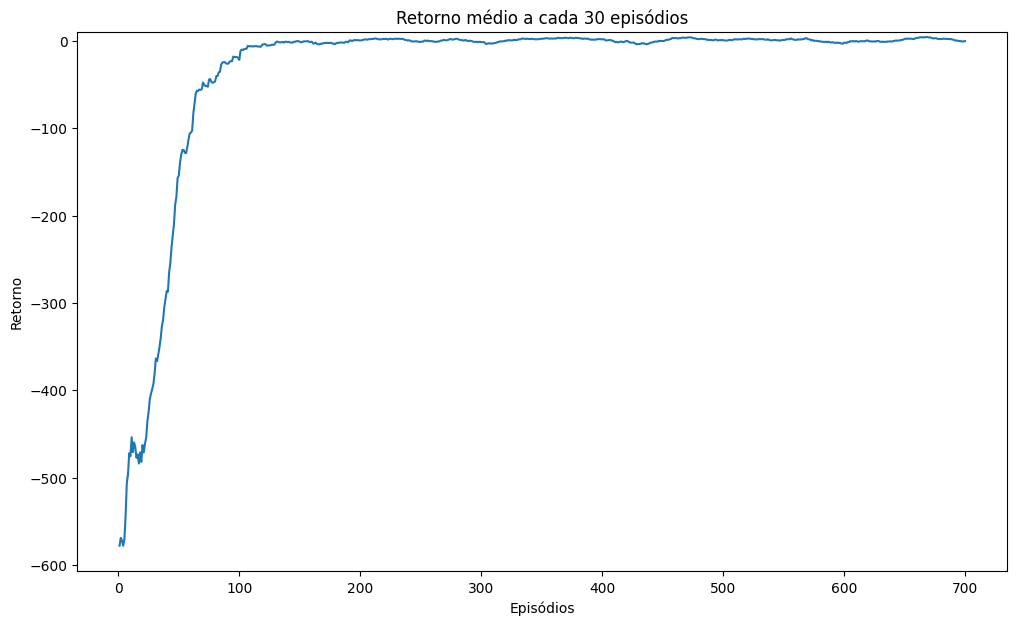

In [ ]:
# Mostra um gráfico de passos x retornos não descontados acumulados
plot_result(rewards2, rmax, cumulative='no', window=30)

In [ ]:
evaluate_qtable_policy(env, qtable2, 10, verbose=True);

Episódio 1: 7.0
Episódio 2: 9.0
Episódio 3: 6.0
Episódio 4: 6.0
Episódio 5: 3.0
Episódio 6: 11.0
Episódio 7: 5.0
Episódio 8: 6.0
Episódio 9: 11.0
Episódio 10: 11.0
Retorno médio (por episódio): 7.50, episódios: 10, total de passos: 135


In [ ]:
record_video_qtable(ENV_NAME, qtable2, episodes=3, folder='./videos-dynaq')

In [ ]:
display_videos_from_path("./videos-dynaq", speed=0.5)

In [4]:
## REMOVER
import random as rand
import gymnasium as gym
import numpy as np
from queue import PriorityQueue
import matplotlib.pyplot as plt
import heapq
from collections import deque

# Dyna-Q com Prioritized Sweeping

 - **Atualizações Prioritárias**: Prioritized Sweeping foca nos estados e ações que mais precisam de atualização, baseando-se em um critério de prioridade como o erro de predição. Isso torna o algoritmo mais eficiente porque direciona o esforço computacional para onde ele é mais necessário.

 - **Convergência Rápida**: Ao realizar atualizações em estados e ações com grandes diferenças de predição, o aprendizado é acelerado. O agente ajusta rapidamente suas políticas e valores de estado para refletir as partes mais críticas do espaço de estados.

 - **Eficiência em Grandes Espaços**: Em ambientes com grandes estados de espaço, Prioritized Sweeping permite que o agente ignore áreas menos relevantes, reduzindo significativamente o tempo necessário para alcançar convergência.
 
 - **Adaptabilidade**: A abordagem de priorização permite que o agente se adapte mais prontamente a mudanças no ambiente ou na dinâmica do modelo, fazendo uso produtivo das informações recentes mais impactantes.

In [ ]:
class DynaQPrioritizedSweeping:
    def __init__(self, env_name, alpha=0.1, gamma=0.95, epsilon=0.1, n_planning=50, theta=0.01):
        if env_name != "FrozenLake-v1":
            self.env = gym.make(env_name)
        else:
            self.env = gym.make(env_name, is_slippery=False)
        self.state_size = self.env.observation_space.n
        self.action_size = self.env.action_space.n
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_planning = n_planning
        self.theta = theta  # Limiar de prioridade

        # Inicialização das estruturas
        self.q_table = np.ones((self.state_size, self.action_size)) * 0.1
        self.model = {}  # (estado, ação) -> (recompensa, próximo_estado)
        self.predecessors = {}  # estado -> set((estado_anterior, ação))
        self.priority_queue = []  # Fila de prioridade para os estados

    def get_priority(self, state, action):
        """Calcula a prioridade (magnitude do erro TD) para um par estado-ação."""
        if (state, action) not in self.model:
            return 0

        reward, next_state = self.model[(state, action)]
        best_next_value = np.max(self.q_table[next_state])
        td_error = abs(reward + self.gamma * best_next_value - self.q_table[state, action])
        return td_error

    def add_to_priority_queue(self, state, action, priority):
        """Adiciona um par estado-ação à fila de prioridade se o erro for significativo."""
        if priority > self.theta:
            heapq.heappush(self.priority_queue, (-priority, (state, action)))

    def update_predecessors(self, state, prev_state, prev_action):
        """Atualiza o mapa de predecessores."""
        if state not in self.predecessors:
            self.predecessors[state] = set()
        self.predecessors[state].add((prev_state, prev_action))

    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        return int(np.argmax(self.q_table[state]))

    def update(self, state, action, reward, next_state):
        # Q-Learning update
        best_next_value = np.max(self.q_table[next_state])
        td_error = reward + self.gamma * best_next_value - self.q_table[state, action]
        self.q_table[state, action] += self.alpha * td_error

        # Atualiza o modelo
        self.model[(state, action)] = (reward, next_state)
        self.update_predecessors(next_state, state, action)

        # Adiciona à fila de prioridade
        priority = abs(td_error)
        self.add_to_priority_queue(state, action, priority)

        # Planning step
        self._planning()

    def _planning(self):
        """Executa o planejamento usando Prioritized Sweeping."""
        for _ in range(self.n_planning):
            if not self.priority_queue:
                break

            # Pega o par estado-ação com maior prioridade
            _, (state, action) = heapq.heappop(self.priority_queue)

            # Atualiza Q-value
            reward, next_state = self.model[(state, action)]
            best_next_value = np.max(self.q_table[next_state])
            td_error = reward + self.gamma * best_next_value - self.q_table[state, action]
            self.q_table[state, action] += self.alpha * td_error

            # Processa predecessores
            if state in self.predecessors:
                for pred_state, pred_action in self.predecessors[state]:
                    priority = self.get_priority(pred_state, pred_action)
                    self.add_to_priority_queue(pred_state, pred_action, priority)

    def train(self, num_episodes, max_steps_per_episode=100):
        rewards_per_episode = []
        avg_rewards = []
        window_size = 10
        rewards_window = deque(maxlen=window_size)

        for episode in range(num_episodes):
            # Compatibilidade com diferentes versões do Gym
            reset_result = self.env.reset()
            state = reset_result if isinstance(reset_result, (int, np.integer)) else reset_result[0]

            episode_reward = 0

            for step in range(max_steps_per_episode):
                action = self.choose_action(state)

                # Compatibilidade com diferentes versões do Gym
                step_result = self.env.step(action)
                if len(step_result) == 4:  # Versão antiga do Gym
                    next_state, reward, done, _ = step_result
                    terminated, truncated = done, False
                else:  # Versão nova do Gym
                    next_state, reward, terminated, truncated, _ = step_result

                self.update(state, action, reward, next_state)
                episode_reward += reward
                state = next_state

                if terminated or truncated:
                    break

            rewards_per_episode.append(episode_reward)
            rewards_window.append(episode_reward)
            avg_rewards.append(np.mean(rewards_window))

            # Decay epsilon
            self.epsilon = max(0.01, self.epsilon * 0.995)

            # if (episode + 1) % 10 == 0:
            #     print(f"Episode {episode + 1}, Average Reward (last {window_size}): {avg_rewards[-1]:.2f}")

        self.plot_learning(rewards_per_episode, avg_rewards, window_size)
        return rewards_per_episode

    def plot_learning(self, rewards, avg_rewards, window_size):
        plt.figure(figsize=(10, 6))
        plt.plot(rewards, alpha=0.3, color='blue', label='Recompensas por Episódio')
        plt.plot(avg_rewards, color='red', label=f'Média Móvel (window={window_size})')
        plt.xlabel('Episódio')
        plt.ylabel('Recompensa')
        plt.title('Curva de Aprendizado - Dyna-Q com Prioritized Sweeping')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

In [6]:
# Observação - FrozenLake está definido para ser determinístico

env_name = "FrozenLake-v1"
frozen_lake_agent = DynaQPrioritizedSweeping(
    env_name,
    alpha=0.1,
    gamma=0.95,
    epsilon=0.1,
    n_planning=50,
    theta=0.01
)

frozen_lake_rewards = frozen_lake_agent.train(num_episodes=5000)
print(f"Treinamento concluído. Recompensa média final: {np.mean(frozen_lake_rewards):.2f}")

KeyboardInterrupt: 

In [ ]:
env_name = "Taxi-v3"
taxi_agent = DynaQPrioritizedSweeping(
    env_name,
    alpha=0.1,
    gamma=0.95,
    epsilon=0.1,
    n_planning=50,
    theta=0.01
)

taxi_rewards = taxi_agent.train(num_episodes=5000)
print(f"Treinamento concluído. Recompensa média final: {np.mean(taxi_rewards):.2f}")

KeyboardInterrupt: 

/home/loumatheu/reinforcement_learning/reinforcement_learning_project/projeto11_RL/dynaq/lib/python3.12/site-packages/gymnasium/envs/registration.py:525: UserWarning: WARN: Using the latest versioned environment `CliffWalking-v0` instead of the unversioned environment `CliffWalking`.
  logger.warn(


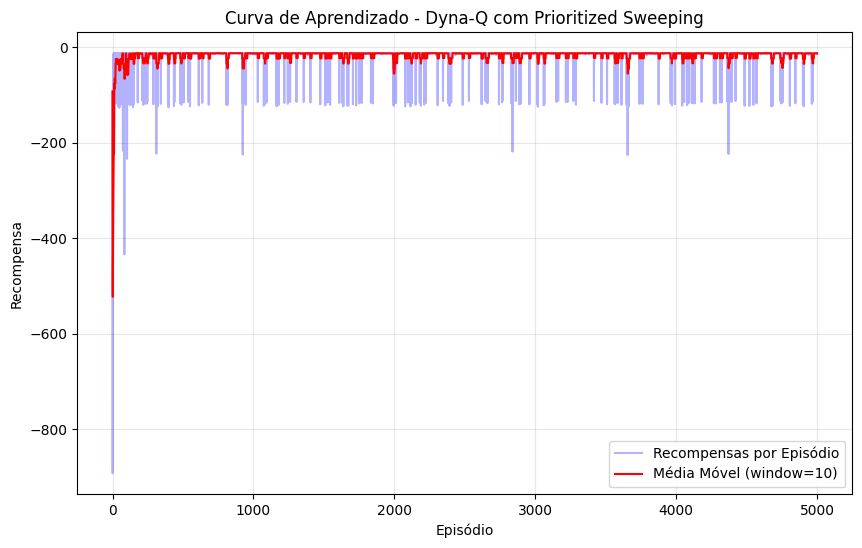

Treinamento concluído. Recompensa média final: -17.59


In [ ]:
env_name = "CliffWalking"
cliffwalking_agent = DynaQPrioritizedSweeping(
    env_name,
    alpha=0.1,
    gamma=0.95,
    epsilon=0.1,
    n_planning=50,
    theta=0.01
)

cliffwalking_rewards = cliffwalking_agent.train(num_episodes=5000)
print(f"Treinamento concluído. Recompensa média final: {np.mean(cliffwalking_rewards):.2f}")